# Aula 2 - feature selection

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Introdução
- 2) Lasso
- 3) Feature importance com árvores
- 4) RFE


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ml_utils import *

____
____
_____

## 1) Introdução

O processo de **feature selection** (**seleção de atributos**) consiste na escolha, com base em alguns critérios, de um **subconjunto do conjunto original** de features de um dado problema, que proporcionem um modelo com performance comparável (e quem sabe até superior) ao modelo treinado com todas as features. 

<img src=https://miro.medium.com/max/694/0*D_jQ5yBsvCZjEYIW width=400>

O resultado do processo de feature selection é uma **redução na dimensionalidade** do espaço de features do problema

> Mas aqui, diferente do PCA, faremos a seleção de features no espaço de features originais (espaço de input)!

Assim, o processo remove features redundantes ou irrelevantes. 

Dentre as vantagens do procedimento, podemos destacar:

- Maior eficiência no treinamento (afinal, reduzimos a quantidade de informação a ser processada);
- Eliminação de redundâncias (como multicolinearidade, por exemplo, que pode ser problemática para alguns estimadores);
- Um modelo mais enxuto, com menos features, é, em geral, mais facilmente interpretável;
- Ao reduzirmos o número de features, a complexidade da hipótese é reduzida, o que pode favorecer a generalização;

O princípio da [navalha de Occam](https://pt.wikipedia.org/wiki/Navalha_de_Ockham) é relevante no contexto de feature selection em projetos de machine learning. Sugiro [este post](https://machinelearningmastery.com/ensemble-learning-and-occams-razor/#:~:text=Occam's%20razor%20suggests%20that%20in,narrow%20and%20not%20generalize%20well.) para uma discussão deste princípio como uma heurística para a construção de modelos. Para uma discussão mais profunda, sugiro [este paper](https://www.aaai.org/Papers/KDD/1998/KDD98-006.pdf).

Há alguns métodos que são sensíveis à atributos irrelevantes. Se eles forem utilizados, o uso de feature selection pode ser muito importante:

 - Regressão Linear e Logística (principalmente se as features forem correlacionadas)
 - KNN
 - SVM
 - Redes Neurais

### Feature selection na pipeline de pré-processamento

Podemos enxergar o feature selection como uma parte da pipeline de pré-processamento de dados:

<img src="https://s3-sa-east-1.amazonaws.com/lcpi/e27aafaa-be21-4793-893c-82db577c62e3.png" width=700>

### Tipos de métodos de feature selection

Assim como temos estimadores supervisionados e não supervisionados, há técnicas de seleção de feature que fazem uso do target ou não.

A seguir, um diagrama com algumas das técnicas de feature selection:

<img src='https://www.kdnuggets.com/wp-content/uploads/Fig1-Butvinik-feature-selection-overview.jpg' text='https://www.kdnuggets.com/2021/06/feature-selection-overview.html'>

Há muitos métodos possíveis. Deixo, a seguir, referências para aprofundamento:

- [Breve introdução dos métodos supervisionados e não supervisionados de seleção de features](https://www.kdnuggets.com/2021/06/feature-selection-overview.html)
- [Lista de estratégias](https://towardsdatascience.com/feature-selection-a-comprehensive-list-of-strategies-3fecdf802b79)
- [MUITOS métodos diferentes](https://medium.com/analytics-vidhya/feature-selection-extended-overview-b58f1d524c1c)
- [Wrapper methods](https://quantifyinghealth.com/stepwise-selection/)
- [Understanding Bias in RF Variable Importance Metrics](https://blog.methodsconsultants.com/posts/be-aware-of-bias-in-rf-variable-importance-metrics/)
- [Sobre as dificuldades de se interpretar os coeficientes da regressão - Statistical Modeling: The Two Cultures (2001) by Leo Breiman (co-creator of Random Forests)](https://projecteuclid.org/euclid.ss/1009213726)
- [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Qual método é melhor?

Como um bom cientista de dados, você terá que realizar vários experimentos para descobrir qual método é melhor para o seu caso!

Mas você pode também usar alguns métodos e selecionar todas as features que foram consideradas importantes por pelo menos 1 ou 2 deles.

Na aula de hoje, veremos alguns destes procedimentos de feature selection. 

Vamos começar!

______________

## 2) LASSO

Já conhecemos um método capaz de realizar feature selection: a **regularização L1 (LASSO)**.

> Como o procedimento de feature selection faz parte do próprio estimador, chamamos essa metodologia de **intrinsic** ou **embedded** feature selection.

Diferente da regularização L2, quando utilizamos regularização L1 é possível zerar alguns dos parâmetros do modelo:

<img src=https://ugc.futurelearn.com/uploads/assets/2b/fe/2bfe399e-503e-4eae-9138-a3d7da738713.png width=800>

Embora ambas as modalidades de regularização tenham sido introduzidas com o intuito de simplificar o espaço de hipóteses, o LASSO faz isso de maneira explítica, efetivamente possibilitando a realização de feature selection!

No entanto, há um problema: são poucos os métodos que têm o LASSO incorporado (ex.: regressão linear, logística, XGBoost).

Assim, se quisermos realizar feature selection utilizando outros estimadores, precisamos de técnicas mais genéricas, que é o que veremos a seguir.

Para utilizarmos o L1, uma abordagem possível é:

- **treinar inicialmente um modelo com LASSO**; 
- identificar quais features **ainda estão presentes no modelo** (isto é, com `coef_` não nulo);
- utilizar estas features apenas para treinar o estimador desejado.

Embora esta seja uma possibilidade, veremos, a seguir, que há técnicas que possibilitam este procedimento, de maneira mais geral!

Vamos nos lembrar brevemente do uso do LASSO pra classificação (incorporado ao método linear da regresão logística), usando o dataset de [qualidade de vinhos](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009):

In [3]:
df_wine_orig = pd.read_csv("../datasets/winequality-red.csv")
                               
df_wine_orig

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
df_wine_orig["quality"].nunique()

6

In [4]:
df_wine_orig["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [5]:
df_wine_orig["quality"].apply(lambda x: "good" if x>5 else "bad")

0        bad
1        bad
2        bad
3       good
4        bad
        ... 
1594     bad
1595    good
1596    good
1597     bad
1598    good
Name: quality, Length: 1599, dtype: object

In [4]:
df_wine = pd.read_csv("../datasets/winequality-red_clf.csv")
                               
df_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,bad
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,bad
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,bad
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,good
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,bad
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,bad
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,good
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,good
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,bad


In [7]:
df_wine["quality"].value_counts()

good    855
bad     744
Name: quality, dtype: int64

In [5]:
X = df_wine.drop(columns="quality")
y = df_wine["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

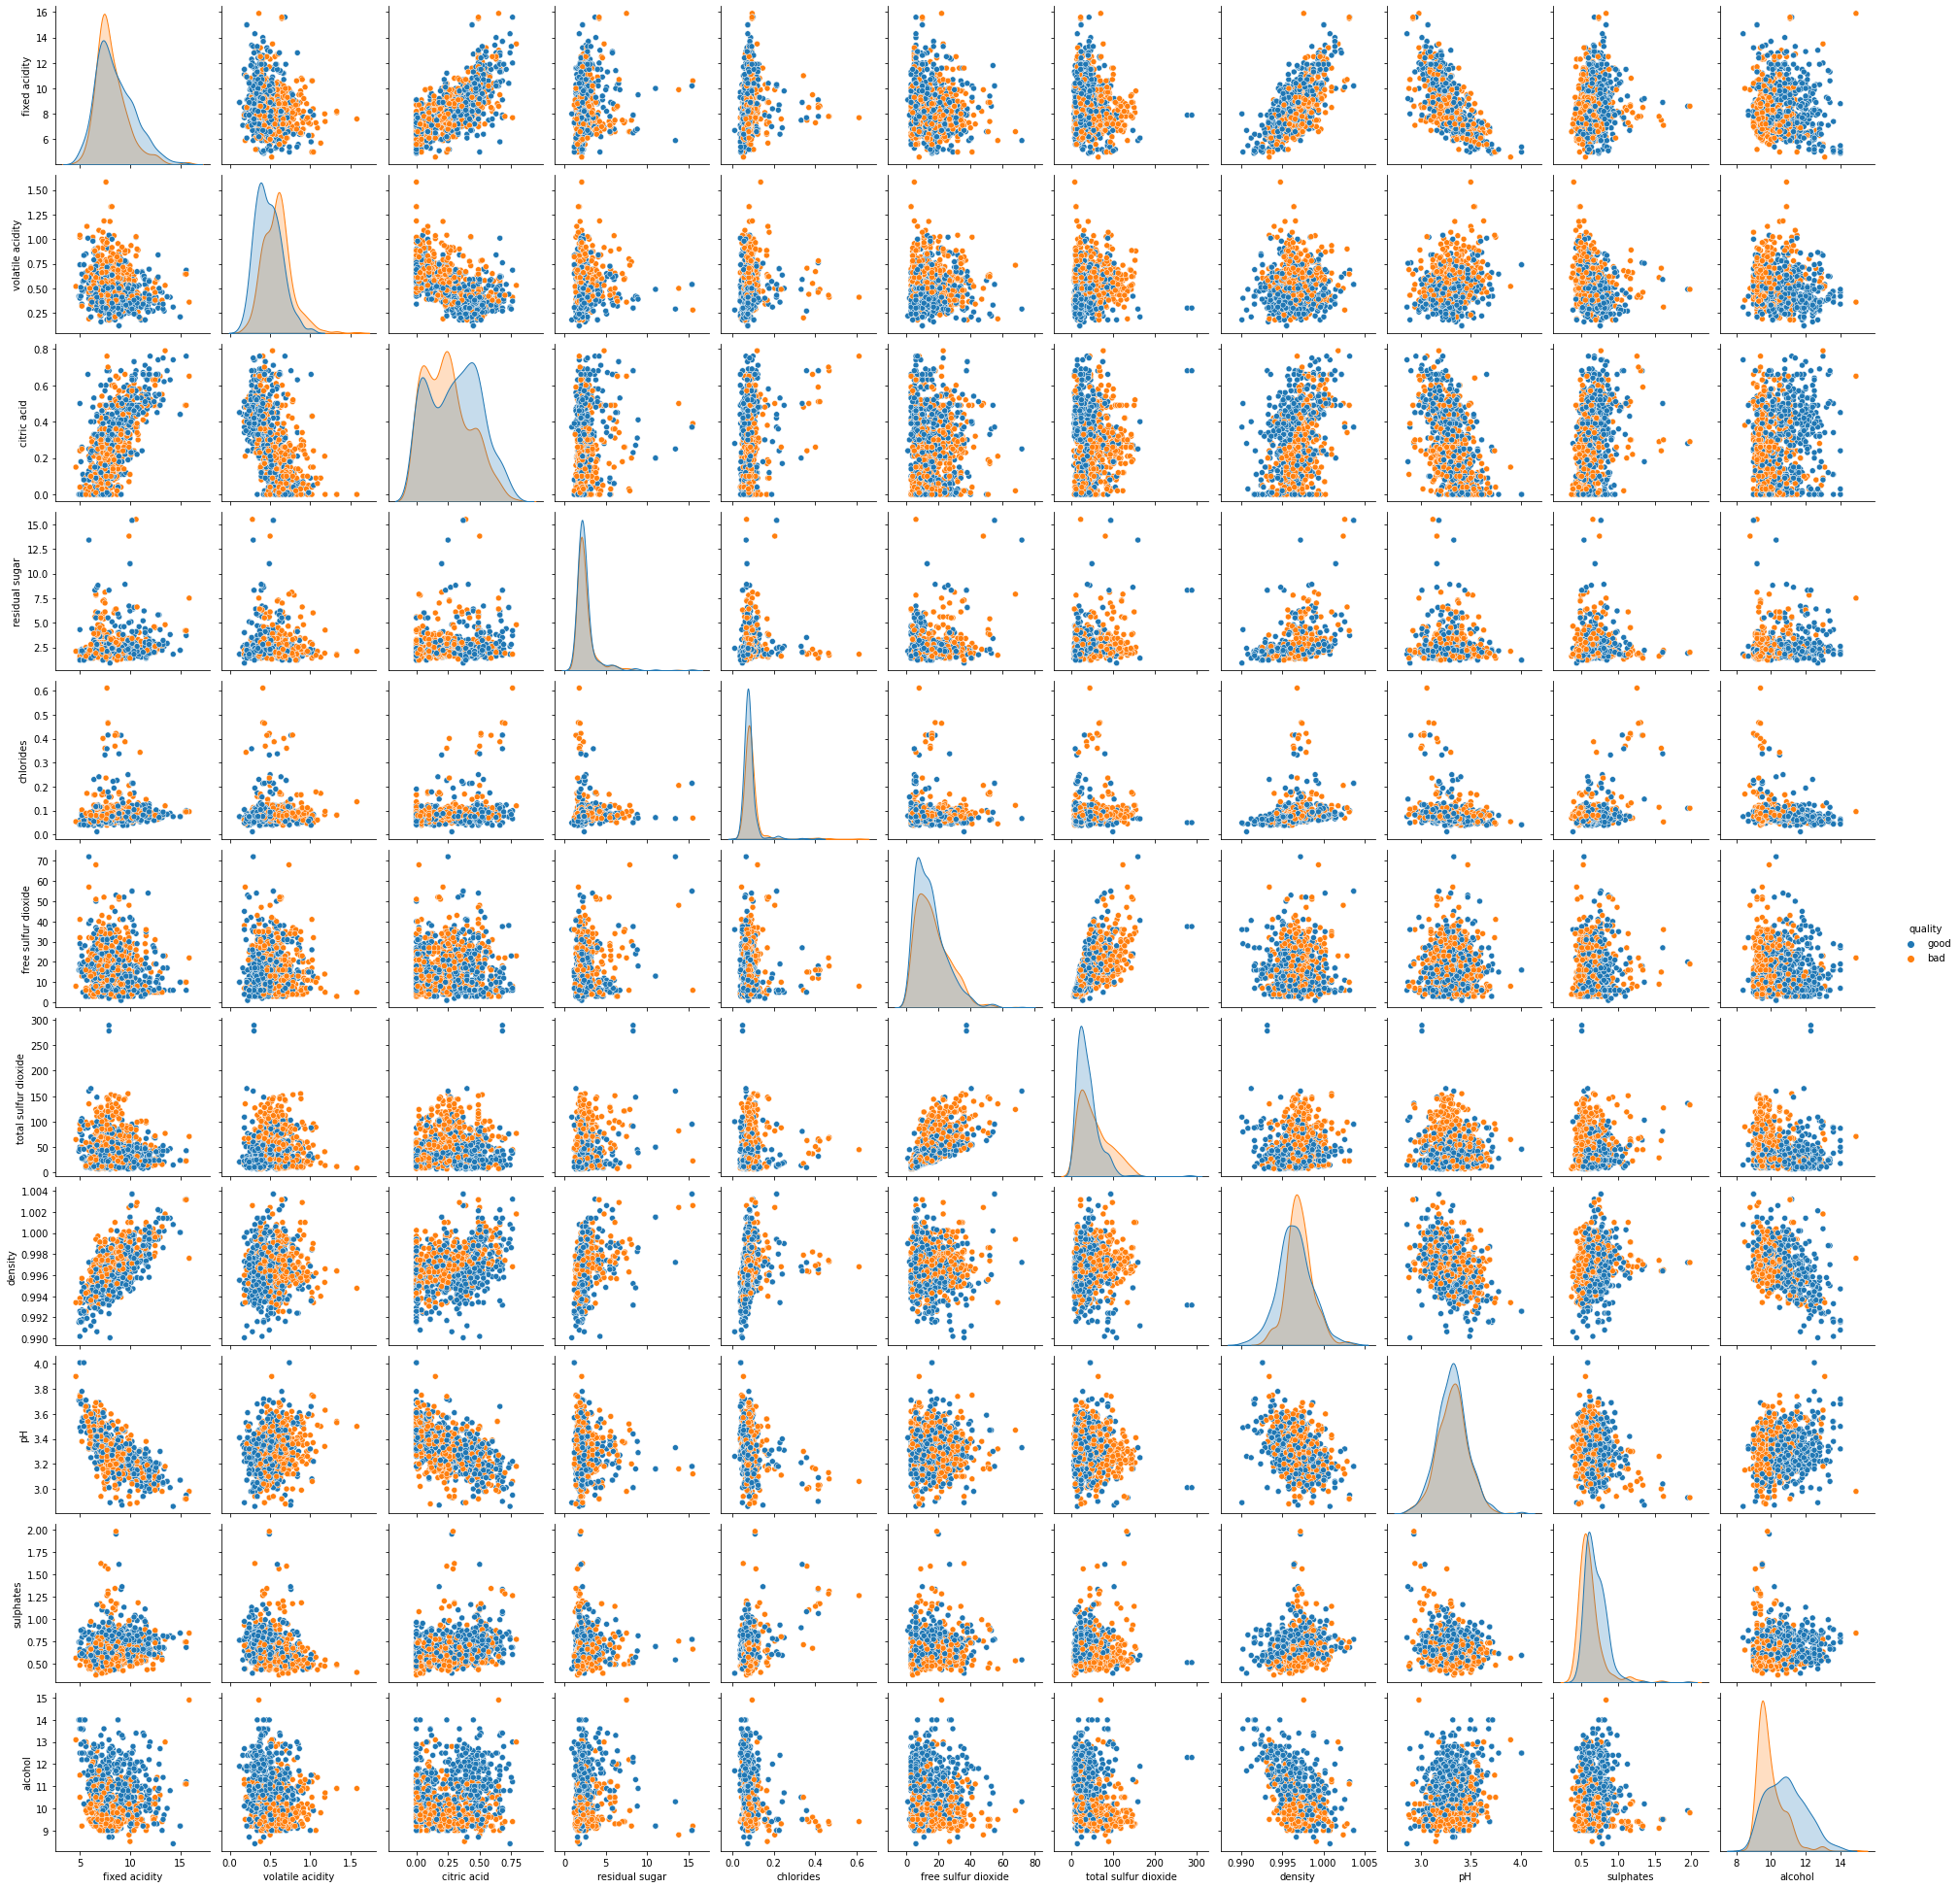

In [9]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), hue="quality");

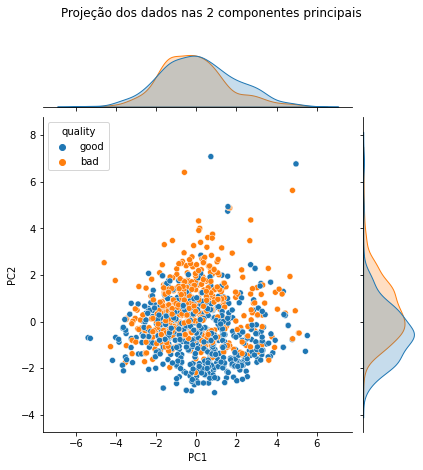

In [10]:
pca_eda(X_train, y_train, 2)

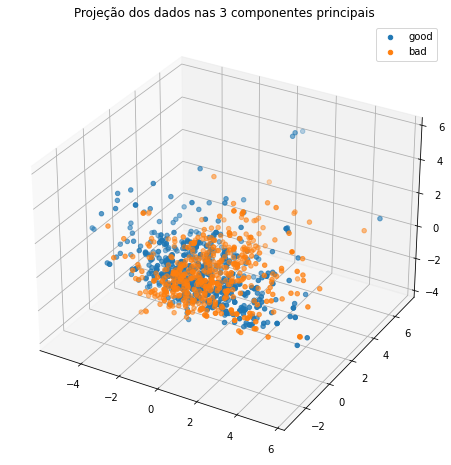

In [11]:
pca_eda(X_train, y_train, 3)

Vamos variar a força de regularização e observar a ação disso nos coeficientes do modelo:

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
forca_reg = 0.1

logit = LogisticRegression(penalty='l1', solver="liblinear", C=forca_reg, random_state=42)

pipe_logit = Pipeline([("ss", StandardScaler()), ("logit", logit)]).fit(X_train, y_train)


`pip install -U scikit-learn`

In [14]:
pipe_logit

Pipeline(steps=[('ss', StandardScaler()),
                ('logit',
                 LogisticRegression(C=0.1, penalty='l1', random_state=42,
                                    solver='liblinear'))])

Métricas de avaliação de treino - com cutoff = 0.50


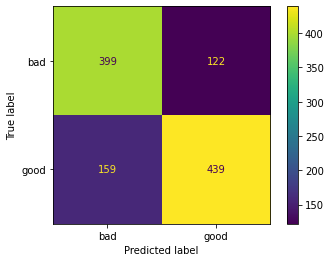

              precision    recall  f1-score   support

         bad       0.72      0.77      0.74       521
        good       0.78      0.73      0.76       598

    accuracy                           0.75      1119
   macro avg       0.75      0.75      0.75      1119
weighted avg       0.75      0.75      0.75      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


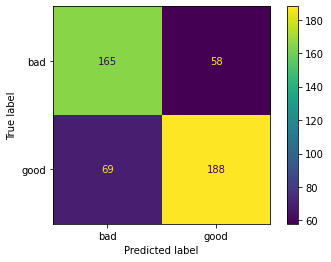

              precision    recall  f1-score   support

         bad       0.71      0.74      0.72       223
        good       0.76      0.73      0.75       257

    accuracy                           0.74       480
   macro avg       0.73      0.74      0.73       480
weighted avg       0.74      0.74      0.74       480



In [15]:
_ = clf_metrics_train_test(pipe_logit, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

In [16]:
pipe_logit["logit"]

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='liblinear')

In [17]:
X_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [18]:
pipe_logit["logit"].coef_.squeeze()

array([ 0.09586646, -0.45935656, -0.06227952,  0.        , -0.11496384,
        0.0677133 , -0.43245436,  0.        , -0.00894434,  0.37470468,
        0.85544836])

In [19]:
results = {"forca_reg" : [], 
           "coefs" : []}

for forca_reg in np.linspace(0.005, 0.5, 200):

    logit = LogisticRegression(penalty='l1', solver="liblinear", C=forca_reg, random_state=42)

    pipe_logit = Pipeline([("ss", StandardScaler()), ("logit", logit)]).fit(X_train, y_train)
    
    # ====================================
    
    results["forca_reg"].append(forca_reg)
    results["coefs"].append(pipe_logit["logit"].coef_.squeeze())
    
#     print(f"\n\nCom C={forca_reg}, temos: ")
#     _ = clf_metrics_train_test(pipe_logit, X_train, y_train, X_test, y_test, cutoff=0.5, 
#                            plot_conf_matrix=True, print_cr=True, pos_label="good")

# ====================================
    
df_results = pd.DataFrame(results)

df_results

,forca_reg,coefs
0,0.005000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.007487,"[0.0, -0.06804582251757069, 0.0, 0.0, 0.0, 0.0..."
2,0.009975,"[0.0, -0.17385561685851808, 0.0, 0.0, 0.0, 0.0..."
3,0.012462,"[0.0, -0.22574377685240554, 0.0, 0.0, 0.0, 0.0..."
4,0.014950,"[0.0, -0.2631278205872843, 0.0, 0.0, 0.0, 0.0,..."
...,...,...
195,0.490050,"[0.31154127352278227, -0.547798109059855, -0.2..."
196,0.492538,"[0.31202045052578337, -0.5479106503233614, -0...."
197,0.495025,"[0.31249490955216475, -0.5480220989496619, -0...."
198,0.497513,"[0.3129647199928309, -0.5481324707773791, -0.2..."


In [20]:
df_results["coefs"][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.12766828])

In [21]:
df_results["coefs"][0] != 0

array([False, False, False, False, False, False, False, False, False,
       False,  True])

In [22]:
(df_results["coefs"][0] != 0).sum()

1

In [23]:
X_train.shape[1]

11

In [24]:
pipe_logit["logit"].n_features_in_

11

In [25]:
# contando o número de parametros não nulos (!= 0) em cada vetor de parametros (pra cada força de regularização)
df_results["n_features_restantes"] = df_results["coefs"].apply(lambda x: (x != 0).sum())

# proporção relativa da qtdd acima (com relação ao numero total de features)
df_results["prop_features_restantes"] = df_results["n_features_restantes"]/pipe_logit["logit"].n_features_in_

In [26]:
df_results

,forca_reg,coefs,n_features_restantes,prop_features_restantes
0,0.005000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,0.090909
1,0.007487,"[0.0, -0.06804582251757069, 0.0, 0.0, 0.0, 0.0...",2,0.181818
2,0.009975,"[0.0, -0.17385561685851808, 0.0, 0.0, 0.0, 0.0...",4,0.363636
3,0.012462,"[0.0, -0.22574377685240554, 0.0, 0.0, 0.0, 0.0...",4,0.363636
4,0.014950,"[0.0, -0.2631278205872843, 0.0, 0.0, 0.0, 0.0,...",4,0.363636
...,...,...,...,...
195,0.490050,"[0.31154127352278227, -0.547798109059855, -0.2...",11,1.000000
196,0.492538,"[0.31202045052578337, -0.5479106503233614, -0....",11,1.000000
197,0.495025,"[0.31249490955216475, -0.5480220989496619, -0....",11,1.000000
198,0.497513,"[0.3129647199928309, -0.5481324707773791, -0.2...",11,1.000000


Vamos visualizar a evolução dos parâmetros (coeficientes) do modelo, como função da força de regularização!

In [27]:
df_results["coefs"]

0      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1      [0.0, -0.06804582251757069, 0.0, 0.0, 0.0, 0.0...
2      [0.0, -0.17385561685851808, 0.0, 0.0, 0.0, 0.0...
3      [0.0, -0.22574377685240554, 0.0, 0.0, 0.0, 0.0...
4      [0.0, -0.2631278205872843, 0.0, 0.0, 0.0, 0.0,...
                             ...                        
195    [0.31154127352278227, -0.547798109059855, -0.2...
196    [0.31202045052578337, -0.5479106503233614, -0....
197    [0.31249490955216475, -0.5480220989496619, -0....
198    [0.3129647199928309, -0.5481324707773791, -0.2...
199    [0.3134299498835964, -0.5482417813403632, -0.2...
Name: coefs, Length: 200, dtype: object

In [28]:
df_coefs = pd.DataFrame(df_results["coefs"].tolist(), columns=X_train.columns)

df_coefs["forca_reg"] = df_results["forca_reg"]

df_coefs

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,forca_reg
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127668,0.005000
1,0.000000,-0.068046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.365000,0.007487
2,0.000000,-0.173856,0.000000,0.000000,0.000000,0.000000,-0.027650,0.000000,0.000000,0.001331,0.478179,0.009975
3,0.000000,-0.225744,0.000000,0.000000,0.000000,0.000000,-0.097470,0.000000,0.000000,0.064443,0.540293,0.012462
4,0.000000,-0.263128,0.000000,0.000000,0.000000,0.000000,-0.146637,0.000000,0.000000,0.107993,0.585960,0.014950
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.311541,-0.547798,-0.262179,0.076209,-0.143202,0.164770,-0.531132,-0.133974,-0.029905,0.461296,0.872138,0.490050
196,0.312020,-0.547911,-0.262451,0.076382,-0.143236,0.164886,-0.531259,-0.134367,-0.029845,0.461444,0.872060,0.492538
197,0.312495,-0.548022,-0.262721,0.076554,-0.143269,0.165000,-0.531385,-0.134756,-0.029785,0.461590,0.871983,0.495025
198,0.312965,-0.548132,-0.262989,0.076723,-0.143302,0.165114,-0.531510,-0.135141,-0.029726,0.461735,0.871907,0.497513


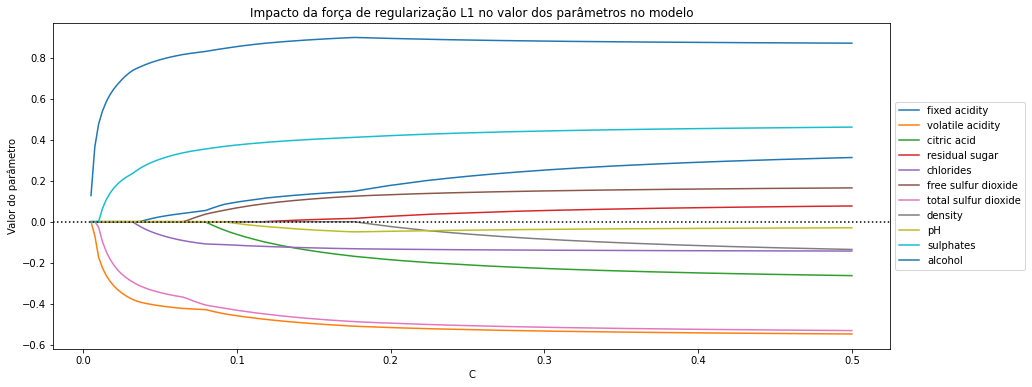

In [29]:
df_coefs.plot(x="forca_reg", figsize=(15, 6))

plt.title("Impacto da força de regularização L1 no valor dos parâmetros no modelo")

plt.ylabel("Valor do parâmetro")
plt.xlabel("C")

plt.axhline(y=0, ls=":", color="k")

plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left")
plt.show()

Vamos ver quantas features sobram no modelo (respectivo parâmetro não-nulo) como função da força de regularização:

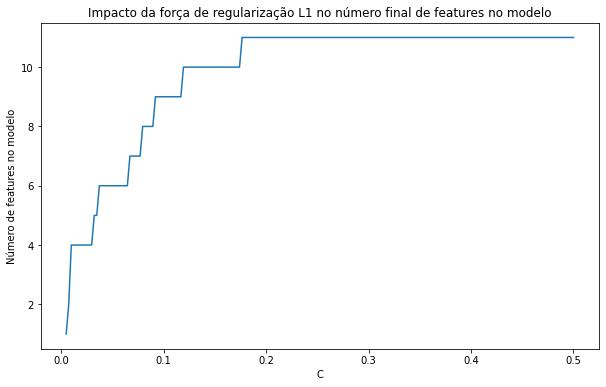

In [30]:
plt.figure(figsize=(10, 6))

plt.title("Impacto da força de regularização L1 no número final de features no modelo")

sns.lineplot(data=df_results, x="forca_reg", y="n_features_restantes")

plt.ylabel("Número de features no modelo")
plt.xlabel("C")

plt.show()

Não se esqueçam que podemos utilizar os valores dos parâmetros do modelo para avaliar a **importância** das features!

> Comos os dados foram escalados, parâmetros de maior valor (em valor absoluto) acompanham as features mais importantes, pois essas features acabam influenciando mais no valor predito (no caso, linearmente no logit!)

Vamos, por exemplo, analisar o experimento de indice 3:

In [31]:
df_coefs.loc[3]

fixed acidity           0.000000
volatile acidity       -0.225744
citric acid             0.000000
residual sugar          0.000000
chlorides               0.000000
free sulfur dioxide     0.000000
total sulfur dioxide   -0.097470
density                 0.000000
pH                      0.000000
sulphates               0.064443
alcohol                 0.540293
forca_reg               0.012462
Name: 3, dtype: float64

In [32]:
aux = df_coefs.drop(columns="forca_reg").loc[3].abs().sort_values(ascending=False)

aux[aux!=0].index

Index(['alcohol', 'volatile acidity', 'total sulfur dioxide', 'sulphates'], dtype='object')

In [33]:
print(*aux[aux!=0].index.tolist(), sep=" > ")

alcohol > volatile acidity > total sulfur dioxide > sulphates


In [34]:
def ranking_importancia_lasso(df_coefs, n):
    '''
    n: indice do experimento que queremos
    '''
    
    forca = df_coefs.loc[n, "forca_reg"]
    
    aux = df_coefs.drop(columns="forca_reg").loc[n].abs().sort_values(ascending=False)

    print(f"Ranking ordenado de importância de feature pro experimento indice {n}, com C = {forca:.3f}:\n")
    
    print(*aux[aux!=0].index.tolist(), sep=" > ")
    
    return aux[aux!=0].index.tolist()

In [35]:
ranking_importancia_lasso(df_coefs, 3)

Ranking ordenado de importância de feature pro experimento indice 3, com C = 0.012:

alcohol > volatile acidity > total sulfur dioxide > sulphates


['alcohol', 'volatile acidity', 'total sulfur dioxide', 'sulphates']

In [36]:
ranking_importancia_lasso(df_coefs, 12)

Ranking ordenado de importância de feature pro experimento indice 12, com C = 0.035:

alcohol > volatile acidity > total sulfur dioxide > sulphates > chlorides


['alcohol',
 'volatile acidity',
 'total sulfur dioxide',
 'sulphates',
 'chlorides']

In [37]:
ranking_importancia_lasso(df_coefs, 34)

Ranking ordenado de importância de feature pro experimento indice 34, com C = 0.090:

alcohol > volatile acidity > total sulfur dioxide > sulphates > chlorides > fixed acidity > free sulfur dioxide > citric acid


['alcohol',
 'volatile acidity',
 'total sulfur dioxide',
 'sulphates',
 'chlorides',
 'fixed acidity',
 'free sulfur dioxide',
 'citric acid']

In [38]:
ranking_importancia_lasso(df_coefs, 154)

Ranking ordenado de importância de feature pro experimento indice 154, com C = 0.388:

alcohol > volatile acidity > total sulfur dioxide > sulphates > fixed acidity > citric acid > free sulfur dioxide > chlorides > density > residual sugar > pH


['alcohol',
 'volatile acidity',
 'total sulfur dioxide',
 'sulphates',
 'fixed acidity',
 'citric acid',
 'free sulfur dioxide',
 'chlorides',
 'density',
 'residual sugar',
 'pH']

______________

## 3) Feature importance com árvores

Além de estimadores poderosos, podemos utilizar árvores para fazer feature selection! 

Há duas formas comuns de utilizarmos árvores para a determinação da importância de features. Vamos conhecer cada uma na prática!

### `.feature_importances_`, com base em decréscimo de impureza (MDI)

Neste caso, o score de importância de cada uma das features é calculado com base na **média e desvio padrão da diminuição de impureza que cada feature proporciona na árvore (ou em cada árvore, no caso de ensembles)**.

O método é conhecido como **mean decrease in impurity** (MDI).

Este método é rápido, no entanto, o valor é fortemente enviesado para features que têm alta cardinalidade (features numéricas, ou features categóricas com muitos níveis).

Neste caso, é melhor utilizar o método de permutation feature importance. Para uma comparação detalhada entre os dois métodos, [veja esta página](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py).

In [39]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)

In [40]:
dt.feature_names_in_

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype=object)

In [41]:
dt.feature_importances_

array([0.06439474, 0.13165922, 0.02714755, 0.062244  , 0.08862861,
       0.04735498, 0.09772108, 0.04444698, 0.04252214, 0.12970822,
       0.26417247])

In [42]:
fi_dt = pd.Series(index=dt.feature_names_in_, data=dt.feature_importances_).sort_values(ascending=False)

fi_dt

alcohol                 0.264172
volatile acidity        0.131659
sulphates               0.129708
total sulfur dioxide    0.097721
chlorides               0.088629
fixed acidity           0.064395
residual sugar          0.062244
free sulfur dioxide     0.047355
density                 0.044447
pH                      0.042522
citric acid             0.027148
dtype: float64

In [43]:
print("Ranking de importâncias das features segundo o MID\n")
print(*fi_dt.index.tolist(), sep=" > ")

Ranking de importâncias das features segundo o MID

alcohol > volatile acidity > sulphates > total sulfur dioxide > chlorides > fixed acidity > residual sugar > free sulfur dioxide > density > pH > citric acid


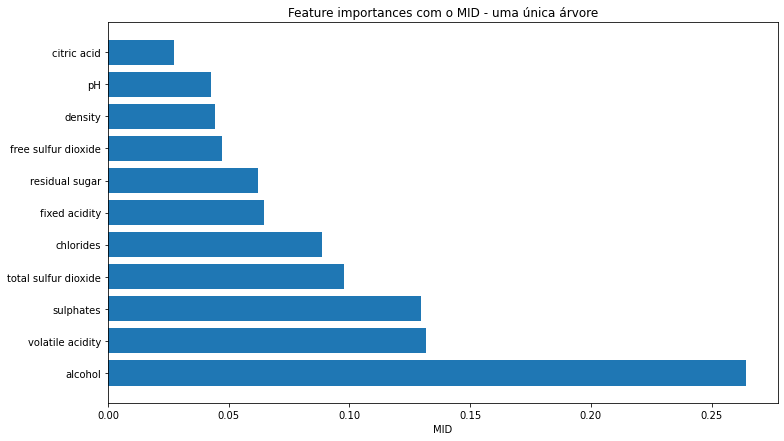

In [44]:
plt.figure(figsize=(12, 7))

plt.title("Feature importances com o MID - uma única árvore")

plt.barh(fi_dt.index, fi_dt.values)

plt.xlabel("MID")

plt.show()

Uma vez que determinamos as features mais importantes, podemos escolher, por exemplo, utilizar apenas as mais importantes na construção de um modelo mais enxuto!

In [45]:
top5_fi_dt = fi_dt.index[:5].tolist()

top5_fi_dt

['alcohol',
 'volatile acidity',
 'sulphates',
 'total sulfur dioxide',
 'chlorides']

Os resultados não são tão legais com uma única árvore. O método fica mais robusto se utilizarmos um ensemble:

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=1000).fit(X_train, y_train)

In [47]:
rf.feature_importances_

array([0.06948853, 0.10478339, 0.06357768, 0.05318968, 0.0745349 ,
       0.05802388, 0.10527908, 0.08776804, 0.06437847, 0.13801102,
       0.18096533])

No caso de ensembles, a importância exibida acima nada mais é que **a média** das importâncias de cada feature em cada uma das árvores no ensemble!

In [48]:
rf.n_estimators

1000

In [49]:
fi_cada_arvore = [rf.estimators_[i].feature_importances_ for i in range(rf.n_estimators)]

np.mean(fi_cada_arvore, axis=0)

array([0.06948853, 0.10478339, 0.06357768, 0.05318968, 0.0745349 ,
       0.05802388, 0.10527908, 0.08776804, 0.06437847, 0.13801102,
       0.18096533])

In [50]:
pd.DataFrame(fi_cada_arvore)

,0,1,2,3,4,5,6,7,8,9,10
0,0.059203,0.084354,0.087476,0.037201,0.085296,0.049963,0.125589,0.152478,0.080934,0.186230,0.051278
1,0.058490,0.105307,0.067554,0.058173,0.060234,0.065390,0.102948,0.069191,0.051581,0.117543,0.243588
2,0.051523,0.118733,0.070289,0.052859,0.086739,0.079811,0.075871,0.037499,0.075418,0.192857,0.158401
3,0.048941,0.150206,0.034829,0.071934,0.085941,0.041780,0.111039,0.150113,0.052064,0.173525,0.079629
4,0.154710,0.078712,0.061951,0.032151,0.046627,0.031314,0.082457,0.179007,0.062842,0.118114,0.152114
...,...,...,...,...,...,...,...,...,...,...,...
995,0.053524,0.068882,0.048828,0.071385,0.067506,0.062454,0.156724,0.070700,0.076329,0.163447,0.160220
996,0.070193,0.147822,0.044649,0.044783,0.086254,0.047820,0.086059,0.061170,0.045690,0.114241,0.251319
997,0.046544,0.087138,0.069732,0.109152,0.108415,0.034823,0.093365,0.039618,0.077517,0.122634,0.211061
998,0.103910,0.096818,0.059582,0.052496,0.091953,0.032677,0.083002,0.149620,0.078947,0.120839,0.130156


In [51]:
np.mean(fi_cada_arvore, axis=0) - rf.feature_importances_

array([2.77555756e-17, 4.16333634e-17, 2.77555756e-17, 2.08166817e-17,
       2.77555756e-17, 2.77555756e-17, 4.16333634e-17, 4.16333634e-17,
       2.77555756e-17, 5.55111512e-17, 8.32667268e-17])

In [52]:
rf.feature_importances_

array([0.06948853, 0.10478339, 0.06357768, 0.05318968, 0.0745349 ,
       0.05802388, 0.10527908, 0.08776804, 0.06437847, 0.13801102,
       0.18096533])

In [53]:
fi_rf = pd.Series(index=rf.feature_names_in_, data=rf.feature_importances_).sort_values(ascending=False)

fi_rf

alcohol                 0.180965
sulphates               0.138011
total sulfur dioxide    0.105279
volatile acidity        0.104783
density                 0.087768
chlorides               0.074535
fixed acidity           0.069489
pH                      0.064378
citric acid             0.063578
free sulfur dioxide     0.058024
residual sugar          0.053190
dtype: float64

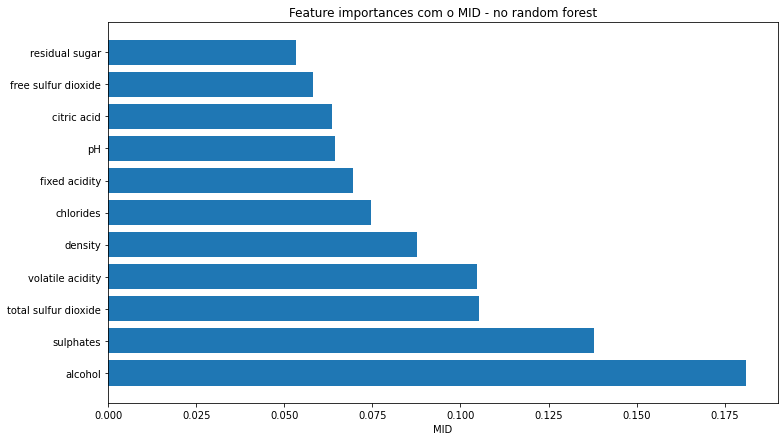

In [54]:
plt.figure(figsize=(12, 7))

plt.title("Feature importances com o MID - no random forest")

plt.barh(fi_rf.index, fi_rf.values)

plt.xlabel("MID")

plt.show()

O legal de usar um método de ensemble, é que podemos levar em consideração também a **variância** das importâncias dentre as árvores no ensemble!

In [55]:
np.std(fi_cada_arvore, axis=0)

array([0.02297534, 0.03488968, 0.02291336, 0.01724759, 0.02279721,
       0.01830887, 0.03150569, 0.03171567, 0.01926693, 0.03489355,
       0.05942035])

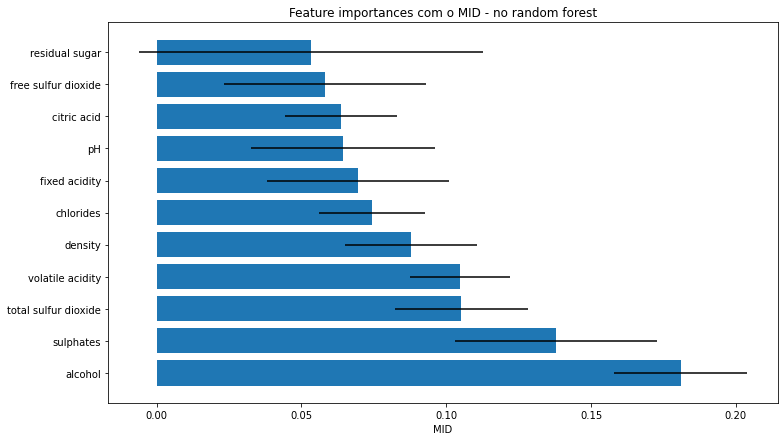

In [56]:
plt.figure(figsize=(12, 7))

plt.title("Feature importances com o MID - no random forest")

# plotando tbm o desvio padrão
plt.barh(fi_rf.index, fi_rf.values, xerr=np.std(fi_cada_arvore, axis=0))

plt.xlabel("MID")

plt.show()

In [57]:
fi_rf

alcohol                 0.180965
sulphates               0.138011
total sulfur dioxide    0.105279
volatile acidity        0.104783
density                 0.087768
chlorides               0.074535
fixed acidity           0.069489
pH                      0.064378
citric acid             0.063578
free sulfur dioxide     0.058024
residual sugar          0.053190
dtype: float64

In [58]:
np.std(fi_cada_arvore, axis=0)

array([0.02297534, 0.03488968, 0.02291336, 0.01724759, 0.02279721,
       0.01830887, 0.03150569, 0.03171567, 0.01926693, 0.03489355,
       0.05942035])

Observamos uma variação bem considerável!

Isso se deve justamente ao viés indesejado que é introduzido pelo MDI. Para corrigir isso, vamos introduzir um novo método a seguir.

Mas, antes disso, vamos comparar as features que foram selecionadas por cada um dos métodos:

In [59]:
top5_fi_rf = fi_rf.index[:5].tolist()

top5_fi_rf

['alcohol', 'sulphates', 'total sulfur dioxide', 'volatile acidity', 'density']

In [60]:
top5_fi_dt

['alcohol',
 'volatile acidity',
 'sulphates',
 'total sulfur dioxide',
 'chlorides']

In [61]:
# vamos pegar tbm uma configuração do LASSO que retornou um modelo com apenas 5 features:
top5_l1 = ranking_importancia_lasso(df_coefs, 12)

top5_l1

Ranking ordenado de importância de feature pro experimento indice 12, com C = 0.035:

alcohol > volatile acidity > total sulfur dioxide > sulphates > chlorides


['alcohol',
 'volatile acidity',
 'total sulfur dioxide',
 'sulphates',
 'chlorides']

In [62]:
[feature for feature in top5_fi_rf if feature not in top5_fi_dt]

['density']

In [63]:
[feature for feature in top5_fi_dt if feature not in top5_fi_rf]

['chlorides']

Comparando com o lasso:

In [64]:
[feature for feature in top5_fi_rf if feature not in top5_l1]

['density']

In [65]:
[feature for feature in top5_fi_dt if feature not in top5_l1]

[]

Vamos conhecer um segundo método, que contribui para diminuirmos a variância observada acima com o MID!

### `permutation_importance()`, com base em permutação de features

Neste método, utilizamos a função `sklearn.inspection.permutation_importance()`, que vai criar permutações das features, mantendo um registro de um score, e como ele é afetado quando uma ou outra feature é eliminada.

Por realizar diversas permutações, este método é mais custoso, mas tem a vantagem de eliminar o viés que features de alta cardinalidade carregam com o método baseado em impureza.

Para maiores detalhes sobre o método, [clique aqui!](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

> Observação: embora tenhamos ilustrado a importância de permutação com a árvore de decisão, na realidade este é um método que pode ser usado com qualquer estimador!

A função que vamos utilizar [está aqui!](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)

In [66]:
from sklearn.inspection import permutation_importance

dt = DecisionTreeClassifier().fit(X_train, y_train)

results_permutation = permutation_importance(dt, X_train, y_train, n_repeats=20, n_jobs=-1,random_state=42)

In [67]:
dt.feature_names_in_

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype=object)

In [68]:
results_permutation.importances_mean

array([0.05558534, 0.1766756 , 0.03820375, 0.04955317, 0.10210009,
       0.0272118 , 0.15848972, 0.03628239, 0.04736372, 0.22104558,
       0.32042002])

In [69]:
results_permutation.importances_std

array([0.00335091, 0.00891015, 0.00337791, 0.00340851, 0.00666283,
       0.0039913 , 0.00791919, 0.00393005, 0.00363004, 0.0115737 ,
       0.01228077])

In [70]:
data = {"importance" : results_permutation.importances_mean,
        "std" : results_permutation.importances_std}

results_perm_imp = pd.DataFrame(data, index=dt.feature_names_in_).sort_values("importance", ascending=False)

results_perm_imp

,importance,std
alcohol,0.320420,0.012281
sulphates,0.221046,0.011574
volatile acidity,0.176676,0.008910
total sulfur dioxide,0.158490,0.007919
chlorides,0.102100,0.006663
fixed acidity,0.055585,0.003351
residual sugar,0.049553,0.003409
pH,0.047364,0.003630
citric acid,0.038204,0.003378
density,0.036282,0.003930


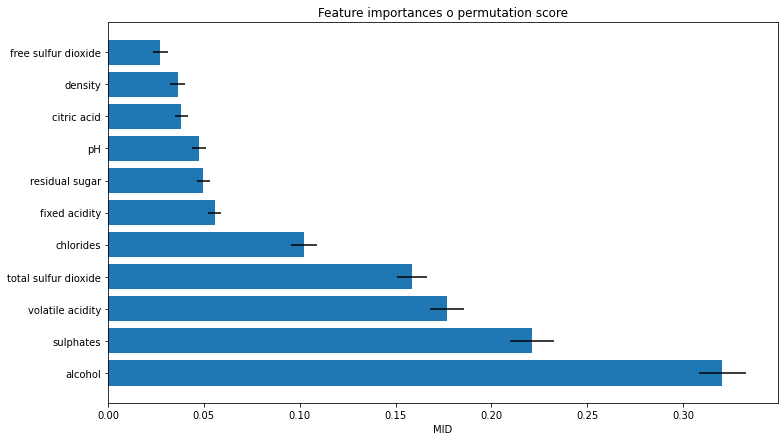

In [71]:
plt.figure(figsize=(12, 7))

plt.title("Feature importances o permutation score")

# plotando tbm o desvio padrão
plt.barh(results_perm_imp.index, results_perm_imp["importance"], xerr=results_perm_imp["std"])

plt.xlabel("MID")

plt.show()

In [72]:
top5_perm = results_perm_imp.index[:5].tolist()

In [73]:
top5_perm

['alcohol',
 'sulphates',
 'volatile acidity',
 'total sulfur dioxide',
 'chlorides']

In [74]:
top5_fi_dt

['alcohol',
 'volatile acidity',
 'sulphates',
 'total sulfur dioxide',
 'chlorides']

In [75]:
top5_fi_rf

['alcohol', 'sulphates', 'total sulfur dioxide', 'volatile acidity', 'density']

In [76]:
top5_l1

['alcohol',
 'volatile acidity',
 'total sulfur dioxide',
 'sulphates',
 'chlorides']

In [77]:
# pra casa: determinar intersecções, etc. das diferentes tecnicas de feature selection

A partir daqui, o próximo passo seria treinar um modelo normalmente (pipeline, gridsearch, etc.), mas apenas com essas features selecionadas (idealmente, uma combinação dessas heurísticas).

Métricas de avaliação de treino - com cutoff = 0.50


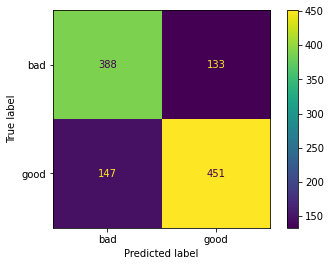

              precision    recall  f1-score   support

         bad       0.73      0.74      0.73       521
        good       0.77      0.75      0.76       598

    accuracy                           0.75      1119
   macro avg       0.75      0.75      0.75      1119
weighted avg       0.75      0.75      0.75      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


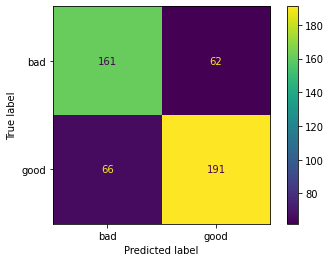

              precision    recall  f1-score   support

         bad       0.71      0.72      0.72       223
        good       0.75      0.74      0.75       257

    accuracy                           0.73       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.73      0.73      0.73       480



In [78]:
# benchmark com todas as features

logit = LogisticRegression(random_state=42)

pipe_logit = Pipeline([("ss", StandardScaler()), ("logit", logit)]).fit(X_train, y_train)

_ = clf_metrics_train_test(pipe_logit, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

Métricas de avaliação de treino - com cutoff = 0.50


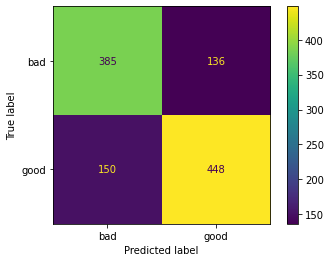

              precision    recall  f1-score   support

         bad       0.72      0.74      0.73       521
        good       0.77      0.75      0.76       598

    accuracy                           0.74      1119
   macro avg       0.74      0.74      0.74      1119
weighted avg       0.75      0.74      0.74      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


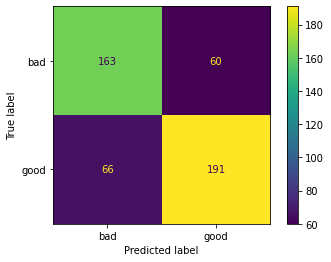

              precision    recall  f1-score   support

         bad       0.71      0.73      0.72       223
        good       0.76      0.74      0.75       257

    accuracy                           0.74       480
   macro avg       0.74      0.74      0.74       480
weighted avg       0.74      0.74      0.74       480



In [79]:
# modelo só com as features selecionadas

logit = LogisticRegression(random_state=42)

pipe_logit = Pipeline([("ss", StandardScaler()), ("logit", logit)]).fit(X_train[top5_perm], y_train)

_ = clf_metrics_train_test(pipe_logit, X_train[top5_perm], y_train, X_test[top5_perm], y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

Vamos tentar com a árvore:

Métricas de avaliação de treino - com cutoff = 0.50


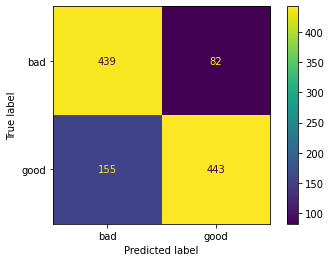

              precision    recall  f1-score   support

         bad       0.74      0.84      0.79       521
        good       0.84      0.74      0.79       598

    accuracy                           0.79      1119
   macro avg       0.79      0.79      0.79      1119
weighted avg       0.80      0.79      0.79      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


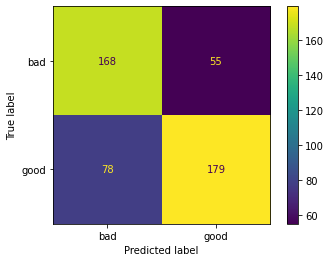

              precision    recall  f1-score   support

         bad       0.68      0.75      0.72       223
        good       0.76      0.70      0.73       257

    accuracy                           0.72       480
   macro avg       0.72      0.72      0.72       480
weighted avg       0.73      0.72      0.72       480



In [80]:
# benchmark com todas as features

tree = DecisionTreeClassifier(max_depth=5, random_state=42)

pipe_tree = Pipeline([("ss", StandardScaler()), ("tree", tree)]).fit(X_train, y_train)

_ = clf_metrics_train_test(pipe_tree, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

Métricas de avaliação de treino - com cutoff = 0.50


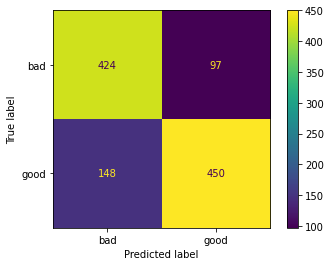

              precision    recall  f1-score   support

         bad       0.74      0.81      0.78       521
        good       0.82      0.75      0.79       598

    accuracy                           0.78      1119
   macro avg       0.78      0.78      0.78      1119
weighted avg       0.78      0.78      0.78      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


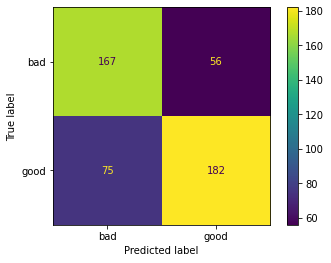

              precision    recall  f1-score   support

         bad       0.69      0.75      0.72       223
        good       0.76      0.71      0.74       257

    accuracy                           0.73       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.73      0.73      0.73       480



In [81]:
# modelo só com as features selecionadas

tree = DecisionTreeClassifier(max_depth=5, random_state=42)

pipe_tree = Pipeline([("ss", StandardScaler()), ("tree", tree)]).fit(X_train[top5_perm], y_train)

_ = clf_metrics_train_test(pipe_tree, X_train[top5_perm], y_train, X_test[top5_perm], y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

______________

## 4) RFE

Conheceremos agora o método **Recursive Feature Elimination** (RFE).

O RFE é um método que se utiliza de um estimador capaz de atribuir um **score de importância** a cada uma das features.

> Por exemplo, podemos olhar para os coeficientes de um modelo linear (`coef_`), ou então, para os scores de importância de features (`feature_importances_`).

O método então considera recursivamente **subconjuntos cada vez menores de features**, da seguinte maneira:

- O estimador é treinado inicialmente com todas as features;
- A importância de cada uma das features é calculada;
- As features menos importantes são retiradas do conjunto de features;
- O processo recomeça, até que o número  desejado de features seja alcançado.

Sendo assim, temos dois hiperparâmetros importantes na classe [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html):

- `estimator`: o estimador que irá disponibilizar os scores de importância de features;
- `n_features_to_select`: a quantidade de features que o subconjunto final terá.

Na prática, podemos utilizar um gridsearch para otimizar estes dois hiperparâmetros, ou então utilizar a classe [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), que determina o melhor númeo de features automaticamente.

Vamos ver o método na prática!

In [82]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5).fit(X_train, y_train)

In [83]:
rfe.feature_names_in_

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype=object)

In [84]:
rfe.support_

array([False,  True, False, False, False, False,  True,  True, False,
        True,  True])

In [85]:
top5_rfe = rfe.feature_names_in_[rfe.support_].tolist()

top5_rfe

['volatile acidity', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']

In [86]:
rfe.ranking_

array([3, 1, 7, 4, 2, 5, 1, 1, 6, 1, 1])

In [87]:
top5_rfe

['volatile acidity', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']

In [88]:
[f for f in top5_rfe if f not in top5_fi_dt]

['density']

In [89]:
[f for f in top5_rfe if f not in top5_fi_rf]

[]

In [90]:
[f for f in top5_rfe if f not in top5_perm]

['density']

In [91]:
[f for f in top5_rfe if f not in top5_l1]

['density']

Métricas de avaliação de treino - com cutoff = 0.50


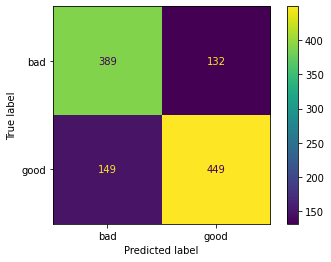

              precision    recall  f1-score   support

         bad       0.72      0.75      0.73       521
        good       0.77      0.75      0.76       598

    accuracy                           0.75      1119
   macro avg       0.75      0.75      0.75      1119
weighted avg       0.75      0.75      0.75      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


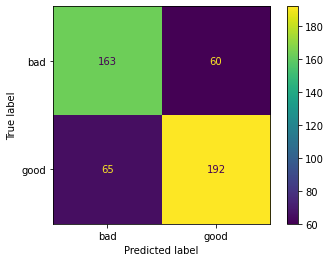

              precision    recall  f1-score   support

         bad       0.71      0.73      0.72       223
        good       0.76      0.75      0.75       257

    accuracy                           0.74       480
   macro avg       0.74      0.74      0.74       480
weighted avg       0.74      0.74      0.74       480



In [92]:
# modelo só com as features selecionadas

logit = LogisticRegression(random_state=42)

pipe_logit = Pipeline([("ss", StandardScaler()), ("logit", logit)]).fit(X_train[top5_rfe], y_train)

_ = clf_metrics_train_test(pipe_logit, X_train[top5_rfe], y_train, X_test[top5_rfe], y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

Vamos ver como funciona o [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html):

In [93]:
from sklearn.feature_selection import RFECV

splitter = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=DecisionTreeClassifier(), cv=splitter, 
              scoring="f1_weighted", n_jobs=-1).fit(X_train, y_train)

In [94]:
rfecv.n_features_

4

In [95]:
top5_rfecv = rfecv.feature_names_in_[rfecv.support_].tolist()

top5_rfecv

['volatile acidity', 'chlorides', 'total sulfur dioxide', 'alcohol']

Métricas de avaliação de treino - com cutoff = 0.50


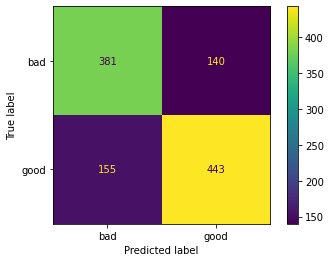

              precision    recall  f1-score   support

         bad       0.71      0.73      0.72       521
        good       0.76      0.74      0.75       598

    accuracy                           0.74      1119
   macro avg       0.74      0.74      0.74      1119
weighted avg       0.74      0.74      0.74      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


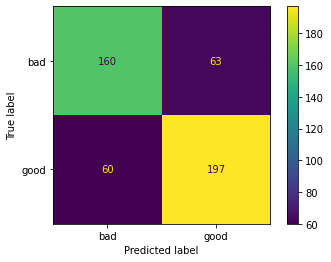

              precision    recall  f1-score   support

         bad       0.73      0.72      0.72       223
        good       0.76      0.77      0.76       257

    accuracy                           0.74       480
   macro avg       0.74      0.74      0.74       480
weighted avg       0.74      0.74      0.74       480



In [96]:
logit = LogisticRegression(random_state=42)

pipe_logit = Pipeline([("ss", StandardScaler()), ("logit", logit)]).fit(X_train[top5_rfecv], y_train)

_ = clf_metrics_train_test(pipe_logit, X_train[top5_rfecv], y_train, X_test[top5_rfecv], y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

Na prática, podemos incluir o RFE como um passo da Pipeline, e otimizar seus parâmetros com o grid search!

Métricas de avaliação de treino - com cutoff = 0.50


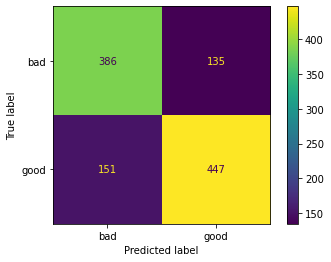

              precision    recall  f1-score   support

         bad       0.72      0.74      0.73       521
        good       0.77      0.75      0.76       598

    accuracy                           0.74      1119
   macro avg       0.74      0.74      0.74      1119
weighted avg       0.75      0.74      0.74      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


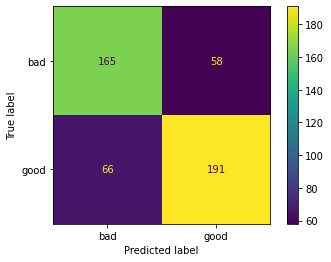

              precision    recall  f1-score   support

         bad       0.71      0.74      0.73       223
        good       0.77      0.74      0.75       257

    accuracy                           0.74       480
   macro avg       0.74      0.74      0.74       480
weighted avg       0.74      0.74      0.74       480



In [97]:
logit = LogisticRegression(random_state=42)

pipe_logit_rfe = Pipeline([("rfe", RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)),
                           ("ss", StandardScaler()),
                           ("logit", logit)])

pipe_logit_rfe.fit(X_train, y_train)

_ = clf_metrics_train_test(pipe_logit_rfe, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

In [98]:
X_train.shape[1]

11

In [99]:
logit = LogisticRegression(random_state=42)

pipe_logit_rfe = Pipeline([("rfe", RFE(estimator=DecisionTreeClassifier())),
                           ("ss", StandardScaler()),
                           ("logit", logit)])

param_grid_logit_rfe = {"rfe__n_features_to_select" : range(1, X_train.shape[1]),
                        "logit__C" : np.linspace(0.005, 0.5, 50)}

splitter = StratifiedKFold(n_splits=5)

grid_logit_rfe = GridSearchCV(pipe_logit_rfe,
                              param_grid_logit_rfe, 
                              cv=splitter, scoring="f1_weighted",
                              verbose=10, n_jobs=-1)

grid_logit_rfe.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('rfe',
                                        RFE(estimator=DecisionTreeClassifier())),
                                       ('ss', StandardScaler()),
                                       ('logit',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'logit__C': array([0.005     , 0.01510204, 0.02520408, 0.03530612, 0.04540816,
       0.0555102 , 0.06561224, 0.07571429, 0.0858...
       0.20704082, 0.21714286, 0.2272449 , 0.23734694, 0.24744898,
       0.25755102, 0.26765306, 0.2777551 , 0.28785714, 0.29795918,
       0.30806122, 0.31816327, 0.32826531, 0.33836735, 0.34846939,
       0.35857143, 0.36867347, 0.37877551, 0.38887755, 0.39897959,
       0.40908163, 0.41918367, 0.42928571, 0.43938776, 0.4494898 ,
       0.45959184, 0.46969388, 0.47979592, 0.48989796, 0.5       ]),
                         'rfe__n_features_to_select': range(1, 11)},
             scoring='f1_weighted', verbose=10)

In [100]:
grid_logit_rfe.best_params_

{'logit__C': 0.2373469387755102, 'rfe__n_features_to_select': 8}

In [101]:
pd.DataFrame(grid_logit_rfe.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
237,0.070066,0.002708,0.011194,0.007517,0.237347,8,"{'logit__C': 0.2373469387755102, 'rfe__n_featu...",0.785971,0.717473,0.749598,0.723479,0.784987,0.752302,0.029165,1
159,0.063764,0.011314,0.010595,0.002058,0.156531,10,"{'logit__C': 0.15653061224489795, 'rfe__n_feat...",0.776999,0.717473,0.758754,0.714559,0.793722,0.752302,0.031638,2
128,0.070360,0.008494,0.008395,0.001496,0.126224,9,"{'logit__C': 0.12622448979591835, 'rfe__n_feat...",0.777053,0.717473,0.758541,0.719003,0.789391,0.752292,0.029492,3
307,0.081955,0.009311,0.008398,0.001358,0.308061,8,"{'logit__C': 0.3080612244897959, 'rfe__n_featu...",0.785971,0.717473,0.749598,0.719003,0.784987,0.751406,0.030090,4
54,0.151737,0.033217,0.015502,0.008139,0.05551,5,"{'logit__C': 0.055510204081632646, 'rfe__n_fea...",0.772571,0.708504,0.753946,0.736844,0.784996,0.751372,0.026964,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.129133,0.005216,0.007897,0.001501,0.146429,1,"{'logit__C': 0.14642857142857144, 'rfe__n_feat...",0.646918,0.682673,0.587771,0.603977,0.455006,0.595269,0.077605,494
340,0.121334,0.009017,0.008391,0.002243,0.348469,1,"{'logit__C': 0.34846938775510206, 'rfe__n_feat...",0.620875,0.682673,0.587771,0.603977,0.455006,0.590061,0.074787,497
120,0.157908,0.016936,0.013991,0.005547,0.126224,1,"{'logit__C': 0.12622448979591835, 'rfe__n_feat...",0.709723,0.373754,0.723214,0.603977,0.455006,0.573135,0.138447,498
370,0.116411,0.005172,0.012001,0.005702,0.378776,1,"{'logit__C': 0.3787755102040816, 'rfe__n_featu...",0.524610,0.682673,0.587771,0.603977,0.455006,0.570807,0.076741,499


Métricas de avaliação de treino - com cutoff = 0.50


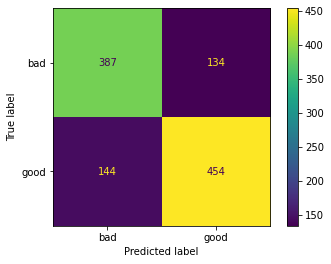

              precision    recall  f1-score   support

         bad       0.73      0.74      0.74       521
        good       0.77      0.76      0.77       598

    accuracy                           0.75      1119
   macro avg       0.75      0.75      0.75      1119
weighted avg       0.75      0.75      0.75      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


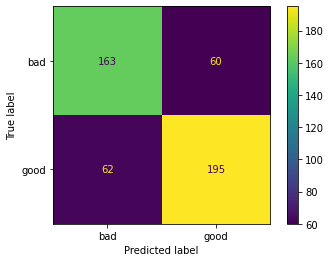

              precision    recall  f1-score   support

         bad       0.72      0.73      0.73       223
        good       0.76      0.76      0.76       257

    accuracy                           0.75       480
   macro avg       0.74      0.74      0.74       480
weighted avg       0.75      0.75      0.75       480



In [102]:
_ = clf_metrics_train_test(grid_logit_rfe, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

In [103]:
from lightgbm import LGBMClassifier

In [116]:
lgbm = LGBMClassifier(random_state=42, reg_alpha=10)

pipe_lgbm_rfe = Pipeline([("rfe", RFE(estimator=DecisionTreeClassifier())),
                          ("lgbm", lgbm)])

param_grid_lgbm_rfe = {"rfe__n_features_to_select" : range(1, X_train.shape[1]+1)}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lgbm_rfe = GridSearchCV(pipe_lgbm_rfe,
                              param_grid_lgbm_rfe, 
                              cv=splitter, scoring="f1_weighted",
                              verbose=10, n_jobs=-1)

grid_lgbm_rfe.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rfe',
                                        RFE(estimator=DecisionTreeClassifier())),
                                       ('lgbm',
                                        LGBMClassifier(random_state=42,
                                                       reg_alpha=10))]),
             n_jobs=-1, param_grid={'rfe__n_features_to_select': range(1, 12)},
             scoring='f1_weighted', verbose=10)

In [117]:
grid_lgbm_rfe.best_params_

{'rfe__n_features_to_select': 11}

Métricas de avaliação de treino - com cutoff = 0.50


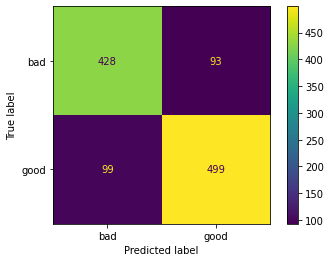

              precision    recall  f1-score   support

         bad       0.81      0.82      0.82       521
        good       0.84      0.83      0.84       598

    accuracy                           0.83      1119
   macro avg       0.83      0.83      0.83      1119
weighted avg       0.83      0.83      0.83      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


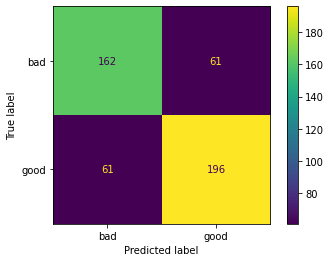

              precision    recall  f1-score   support

         bad       0.73      0.73      0.73       223
        good       0.76      0.76      0.76       257

    accuracy                           0.75       480
   macro avg       0.74      0.74      0.74       480
weighted avg       0.75      0.75      0.75       480



In [118]:
_ = clf_metrics_train_test(grid_lgbm_rfe, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

Vamos mudar o estimador do RFE - usamos a regressão logística com o LASSO!

Ou seja, estamos usando os `.coef_` pra atribuir a importância das features

In [25]:
logit_rfe = LogisticRegression(penalty='l1', solver="liblinear", random_state=42)
pipe_logit_input_rfe = Pipeline([("ss", StandardScaler()), ("logit_rfe", logit_rfe)])

logit = LogisticRegression(random_state=42)

pipe_logit_rfe = Pipeline([("rfe", RFE(estimator=pipe_logit_input_rfe, 
                                       importance_getter="named_steps.logit_rfe.coef_")),
                           ("ss", StandardScaler()),
                           ("logit", logit)])

param_grid_logit_rfe = {"rfe__n_features_to_select" : range(1, X_train.shape[1]),
                        "logit__C" : np.linspace(0.005, 0.5, 50)}

splitter = StratifiedKFold(n_splits=5)

grid_logit_rfe = GridSearchCV(pipe_logit_rfe,
                              param_grid_logit_rfe, 
                              cv=splitter, scoring="f1_weighted",
                              verbose=10, n_jobs=-1)

grid_logit_rfe.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('rfe',
                                        RFE(estimator=Pipeline(steps=[('ss',
                                                                       StandardScaler()),
                                                                      ('logit_rfe',
                                                                       LogisticRegression(penalty='l1',
                                                                                          random_state=42,
                                                                                          solver='liblinear'))]),
                                            importance_getter='named_steps.logit_rfe.coef_')),
                                       ('ss', StandardScaler()),
                                       ('logit',
                                        LogisticRegression(r...
       0.20704082, 0.21714286, 0.2272449 , 0.23734694, 0.24744898,
       0.25755102, 0.26765306, 0.2777551 , 0.28785714, 0.29795918,
       0.30806122, 0.31816327, 0.32826531, 0.33836735, 0.34846939,
       0.35857143, 0.36867347, 0.37877551, 0.38887755, 0.39897959,
       0.40908163, 0.41918367, 0.42928571, 0.43938776, 0.4494898 ,
       0.45959184, 0.46969388, 0.47979592, 0.48989796, 0.5       ]),
                         'rfe__n_features_to_select': range(1, 11)},
             scoring='f1_weighted', verbose=10)

Métricas de avaliação de treino - com cutoff = 0.50


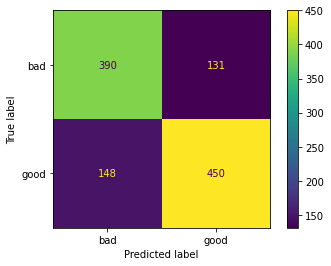

              precision    recall  f1-score   support

         bad       0.72      0.75      0.74       521
        good       0.77      0.75      0.76       598

    accuracy                           0.75      1119
   macro avg       0.75      0.75      0.75      1119
weighted avg       0.75      0.75      0.75      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


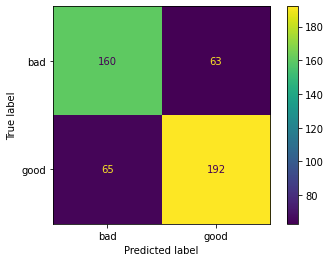

              precision    recall  f1-score   support

         bad       0.71      0.72      0.71       223
        good       0.75      0.75      0.75       257

    accuracy                           0.73       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.73      0.73      0.73       480



In [26]:
_ = clf_metrics_train_test(grid_logit_rfe, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

In [31]:
logit_rfe = LogisticRegression(penalty='l1', solver="liblinear", random_state=42)
pipe_logit_input_rfe = Pipeline([("ss", StandardScaler()), ("logit_rfe", logit_rfe)])

lgbm = LGBMClassifier(random_state=42, reg_alpha=10)

pipe_lgbm_rfe = Pipeline([("rfe", RFE(estimator=pipe_logit_input_rfe, 
                                      importance_getter="named_steps.logit_rfe.coef_")),
                          ("lgbm", lgbm)])

param_grid_lgbm_rfe = {"rfe__n_features_to_select" : range(1, X_train.shape[1]+1)}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lgbm_rfe = GridSearchCV(pipe_lgbm_rfe,
                              param_grid_lgbm_rfe, 
                              cv=splitter, scoring="f1_weighted",
                              verbose=10, n_jobs=-1)

grid_lgbm_rfe.fit(X_train, y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rfe',
                                        RFE(estimator=Pipeline(steps=[('ss',
                                                                       StandardScaler()),
                                                                      ('logit_rfe',
                                                                       LogisticRegression(penalty='l1',
                                                                                          random_state=42,
                                                                                          solver='liblinear'))]),
                                            importance_getter='named_steps.logit_rfe.coef_')),
                                       ('lgbm',
                                        LGBMClassifier(random_state=42,
                                                       reg_alpha=10))]),
             n_jobs=-1, param_grid={'rfe__n_features_to_select': range(1, 12)},
             scoring='f1_weighted', verbose=10)

Métricas de avaliação de treino - com cutoff = 0.50


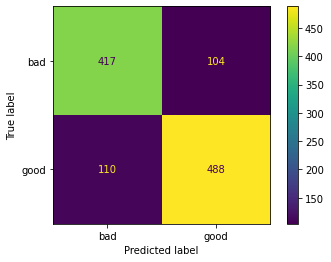

              precision    recall  f1-score   support

         bad       0.79      0.80      0.80       521
        good       0.82      0.82      0.82       598

    accuracy                           0.81      1119
   macro avg       0.81      0.81      0.81      1119
weighted avg       0.81      0.81      0.81      1119


################################################################################

Métricas de avaliação de teste - com cutoff = 0.50


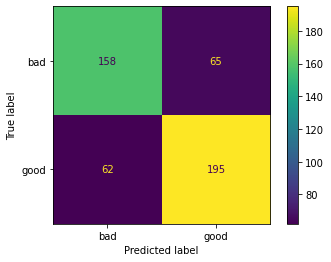

              precision    recall  f1-score   support

         bad       0.72      0.71      0.71       223
        good       0.75      0.76      0.75       257

    accuracy                           0.74       480
   macro avg       0.73      0.73      0.73       480
weighted avg       0.74      0.74      0.74       480



In [32]:
_ = clf_metrics_train_test(grid_lgbm_rfe, X_train, y_train, X_test, y_test, cutoff=0.5, 
                           plot_conf_matrix=True, print_cr=True, pos_label="good")

________

E com isso finalizamos nossa aula sobre feature selection.

Agora temos mais uma ferramenta muito poderosa à nossa disposição, não deixe de considerar usá-la como parte das técnicas do ciclo de modelagem!